The neural network is being created by taking reference of the "Neural Probabilistic Language" Paper instead of like them using words of 17000 we have done it for character level and for 10 dimmension instead of 30 dimension given in the paper

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
def build_dataset(words):
    # build the dataset

    block_size = 3 #context length: how many characters do we take to predict the next one ?
    X, Y = [], []
    for word in words:
        # print(word)
        context = [0] * block_size
        # print(context)
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [57]:
len(words)

32033

In [58]:
n1

25626

In [59]:
n2

28829

In [60]:
n2 - n1

3203

In [61]:
len(words) - n2

3204

In [62]:
C = torch.randn((27,2))

In [63]:
emb = C[Xtr]
emb.shape

torch.Size([182580, 3, 2])

In [64]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [65]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [66]:
sum(p.nelement() for p in parameters) #number of parameters in total

11897

In [67]:
for p in parameters:
    p.requires_grad = True

In [68]:
lre = torch.linspace(-3, 0, 1000) # determining the learning rate 
lrs = 10 ** lre

In [69]:
lri = []
lossi = []
stepi = []

In [76]:

for i in range(200000):
    # minibatch construct 
    ix = torch.randint(0,Xtr.shape[0],(32,)) # generates a 1D tensor of shape (32,) containing 32 random integers. Each integer is drawn from the range [0, X.shape[0])
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


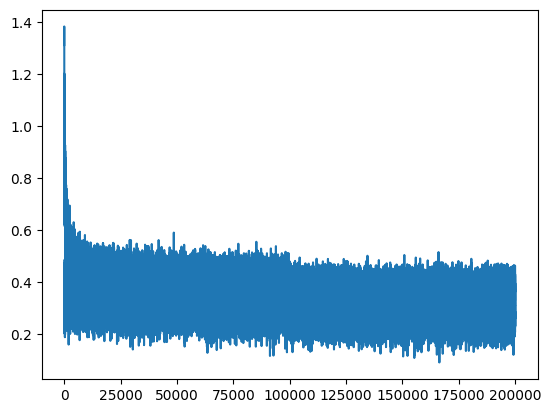

In [77]:
plt.plot(stepi,lossi)

In [78]:
print(loss.item())

2.017167806625366


In [79]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1372, grad_fn=<NllLossBackward0>)

In [80]:
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1366, grad_fn=<NllLossBackward0>)

In [83]:
# sample from the model

block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initiate all with ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


carmah.
ambrilli.
kimri.
reh.
cassandan.
jazon.
nadelynn.
jareen.
nellara.
chriiv.
kaleigh.
ham.
joir.
quinthonor.
raiviani.
waje.
madiaristin.
jenni.
sabeed.
edi.
